In [1]:
import sys
import psrchive
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import chirp, find_peaks, peak_widths
from scipy.optimize import curve_fit
import scipy.optimize as opt
from scipy.cluster.vq import kmeans, vq
import scipy.stats as stats
from matplotlib import colors
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter
from scipy import ndimage

In [2]:
def Read_File(file_path, dedisperse = True):
    File = psrchive.Archive_load(file_path)
    File.tscrunch()
    if dedisperse == True:
        File.dedisperse()
    File.pscrunch()
    File.remove_baseline()
    dm = File.get_dispersion_measure()
    center_freq = File.get_centre_frequency()
    integration = File.get_first_Integration()
    period = integration.get_folding_period()
    File_Data = File.get_data()
    #pulse = File_Data[0,0,:] #Select usable part of data
    
    #Get a list of the frequencies
    freq_mhz_table = File.get_frequency_table()
    freq_mhz = freq_mhz_table[0]
    
    # Get weights
    ww = np.array(File.get_weights(), dtype=bool)
    # Create array with only True with same shape as data
    wts = np.ones(File_Data.shape, dtype=bool)
    print("ww shape: " + str(np.shape(ww)))
    print("wts shape: " + str(np.shape(wts)))
    # If True in ww, set to false in wts
    # Essentially, creates the opposite of ww
    wts[...,ww,:] = False
    # set all values in data with True in wts to nan
    mata = File_Data.copy()
    mata[wts] = np.nan
    pulse = mata[0,0,:]
    
    
    return(pulse, freq_mhz, dm, center_freq, period)

In [3]:
def map_to_zero_one(arr):
    min_val = np.min(arr)
    max_val = np.max(arr)
    scaled_arr = (arr - min_val) / (max_val - min_val)
    return scaled_arr

In [4]:
#Get first band data
band1_path = "/srv/storage_11/galc/UBB/jtremblay/20240216/B0355+54_added_clean1.ar"
band1_data, band1_freq, band1_dm, band1_centerfreq, band1_period = Read_File(band1_path)
#Get second band data
band2_path = "/srv/storage_11/galc/UBB/jtremblay/20240216/B0355+54_added_clean2.ar"
band2_data, band2_freq, band2_dm, band2_centerfreq, band2_period = Read_File(band2_path)
#Create an empty array for the missing frequencies
band3_data = np.full((387, 1024), np.nan) #385
band3_freq = np.arange(2589, 2976, 1.0)
#Get fourth band data
band4_path = "/srv/storage_11/galc/UBB/jtremblay/20240216/B0355+54_added_clean3.ar"
band4_data, band4_freq, band4_dm, band4_centerfreq, band4_period = Read_File(band4_path)
#Get fifth band data
band5_path = "/srv/storage_11/galc/UBB/jtremblay/20240216/B0355+54_added_clean4.ar"
band5_data, band5_freq, band5_dm, band5_centerfreq, band5_period = Read_File(band5_path)
#Get sixth band data
band6_path = "/srv/storage_11/galc/UBB/jtremblay/20240216/B0355+54_added_clean5.ar"
band6_data, band6_freq, band6_dm, band6_centerfreq, band6_period = Read_File(band6_path)


ww shape: (1, 640)
wts shape: (1, 1, 640, 1024)
ww shape: (1, 640)
wts shape: (1, 1, 640, 1024)
ww shape: (1, 1200)
wts shape: (1, 1, 1200, 1024)
ww shape: (1, 1200)
wts shape: (1, 1, 1200, 1024)
ww shape: (1, 800)
wts shape: (1, 1, 800, 1024)


In [5]:
# Resize arrays to (1280, 1024) using bilinear interpolation
band1_data_resize = ndimage.zoom(band1_data, (650/1280, 1024/1024), order=1)
band2_data_resize = ndimage.zoom(band2_data, (650/1280, 1024/1024), order=1)
band4_data_resize = ndimage.zoom(band4_data, (1125/2400, 1024/1024), order=1)
band5_data_resize = ndimage.zoom(band5_data, (1125/2400, 1024/1024), order=1)
band6_data_resize = ndimage.zoom(band6_data, (750/1600, 1024/1024), order=1)

In [6]:
band1_freq_resize = ndimage.zoom(band1_freq, (650/1280), order=1)
band2_freq_resize = ndimage.zoom(band2_freq, (650/1280), order=1)
band4_freq_resize = ndimage.zoom(band4_freq, (1125/2400), order=1)
band5_freq_resize = ndimage.zoom(band5_freq, (1125/2400), order=1)
band6_freq_resize = ndimage.zoom(band6_freq, (750/1600), order=1)

In [7]:
full_data = np.concatenate((band1_data_resize, band2_data_resize, band3_data, band4_data_resize, band5_data_resize,  band6_data_resize), axis=0)
#full_freqs = np.arange(1290.097, 5976.328, 9998359291657778)  ##concatenate((band1_freq, band2_freq, band3_freq, band4_freq, band5_freq, band6_freq), axis=0)
full_freqs = np.concatenate((band1_freq_resize, band2_freq_resize, band3_freq, band4_freq_resize, band5_freq_resize,  band6_freq_resize), axis=0)
# Sort the frequencies and data accordingly
#sorted_indices = np.argsort(full_freqs)
#sorted_freqs = full_freqs[sorted_indices]
#sorted_data = full_data[sorted_indices, :]
#print(sorted_freqs)
# Compute subsampled frequencies
subsample_indices = np.arange(0, len(full_freqs), step=200)
subsampled_frequencies = full_freqs[subsample_indices]

In [8]:
# Assuming you have an array of y-tick values called full_freqs
#full_freqs_reshape = np.linspace(full_freqs[0], full_freqs[-1], num=10)
time_range = np.arange(0,1024)
#Convert x-axis to degrees
time_range_turns = map_to_zero_one(time_range)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("plasma"))
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  # Remove the CWD from sys.path while we load stuff.


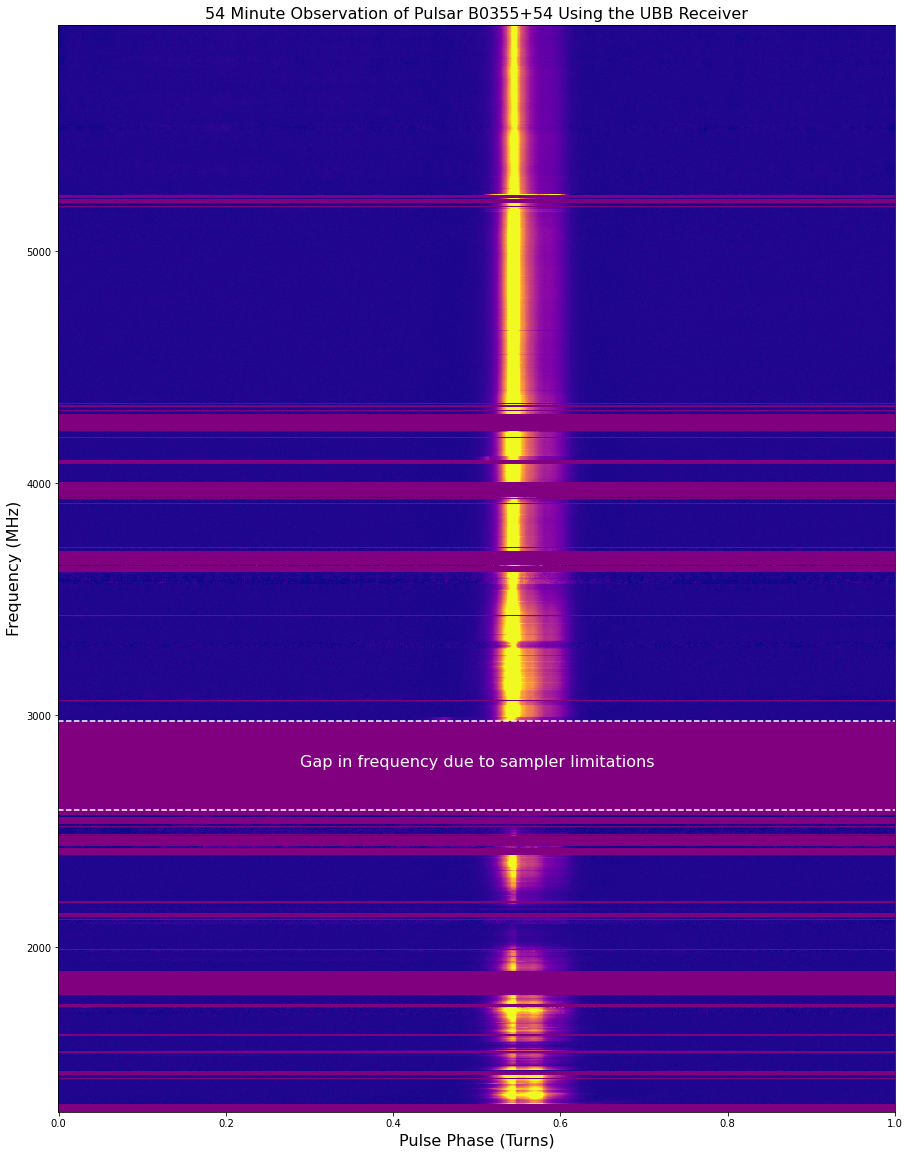

In [9]:
fig = plt.figure(figsize=(15, 20))  # Set figure size directly in the figure call
ax = fig.add_subplot(111)  # Add subplot

#Set colormap
# Create a colormap with purple color
cmap = plt.cm.plasma  # You can use any other colormap as well
cmap.set_bad(color='purple')

# Create the plot using pcolormesh
pcm = ax.pcolormesh(time_range_turns, full_freqs, full_data, cmap=cmap, vmin=np.nanpercentile(full_data, 1), vmax=np.nanpercentile(full_data, 99), shading='nearest')

# Set aspect ratio
ax.set_aspect('auto')

# Calculate the coordinates of the middle of the plot
middle_index = len(time_range_turns) // 2
x_mid = time_range_turns[middle_index]
y_mid = 2800 #full_data.shape[0] / 1.8

# Add text in the middle of the plot
text = 'Gap in frequency due to sampler limitations'
plt.text(x_mid, y_mid, text, color='white', ha='center', va='center', fontsize=16)
plt.axhline(y=2976, color='w', linestyle='--')
plt.axhline(y=2590, color='w', linestyle='--')

# Add colorbar
#cbar = fig.colorbar(pcm)

plt.title('54 Minute Observation of Pulsar B0355+54 Using the UBB Receiver', fontsize=16)
plt.ylabel("Frequency (MHz)", fontsize=16)
plt.xlabel("Pulse Phase (Turns)", fontsize=16)
plt.show()
plt.close()